In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot_tools import plot_groups, plot_input_image
%matplotlib inline
np.random.seed(516371)

/home/greff/venv/py3/lib/python3.4/site-packages/matplotlib-1.5.0+783.g23bc09d-py3.4-linux-x86_64.egg/matplotlib/__init__.py:877: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Adapted Bars Problem

Binary images with a fixed number of randomly placed horizontal and vertical bars.
    
With width=height=20 and nr_horizontal_bars=nr_vertical_bars=6 this mimics the setup from [2].

In [2]:
def generate_bars(width, height, nr_horizontal_bars, nr_vertical_bars):
    img = np.zeros((height, width), dtype=np.float)
    grp = np.zeros_like(img)
    
    idx_vert = np.random.choice(np.arange(width), replace=False, size=nr_vertical_bars)
    img[:, idx_vert] = 1.
    k = 1
    for i in idx_vert:
        grp[:, i] = k
        k += 1
    
    idx_horiz = np.random.choice(np.arange(height), replace=False, size=nr_horizontal_bars)
    img[idx_horiz, :] += 1.
    for i in idx_horiz:
        grp[i, :] = k
        k += 1
    
    grp[img > 1] = 0
    img = img != 0
    
    return img, grp
    

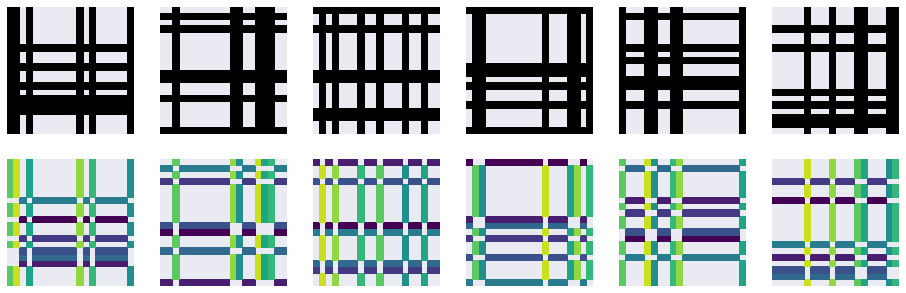

In [3]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(16,5))
for ax in axes.T:
    img, grp = generate_bars(20, 20, 6, 6)
    plot_input_image(img, ax[0])
    plot_groups(grp, ax[1])

# Save as HDF5 Dataset


In [4]:
import h5py
import os
import os.path

data_dir = os.environ.get('BRAINSTORM_DATA_DIR', '.')

In [5]:
np.random.seed(471958)
nr_train_examples = 60000
nr_test_examples = 10000
nr_single_examples = 200
width = 20
height = 20
nr_vert = 6
nr_horiz= 6

data = np.zeros((1, nr_train_examples, height, width, 1), dtype=np.float32)
grps = np.zeros_like(data)
for i in range(nr_train_examples):
    data[0, i, :, :, 0], grps[0, i, :, :, 0] = generate_bars(width, height, nr_horiz, nr_vert)

test_data = np.zeros((1, nr_train_examples, height, width, 1), dtype=np.float32)
test_grps = np.zeros_like(test_data)
for i in range(nr_train_examples):
    test_data[0, i, :, :, 0], test_grps[0, i, :, :, 0] = generate_bars(width, height, nr_horiz, nr_vert)

single_data = np.zeros((1, nr_single_examples, height, width, 1), dtype=np.float32)
single_grps = np.zeros_like(single_data)
for i in range(nr_single_examples // 2):
    single_data[0, i, :, :, 0], single_grps[0, i, :, :, 0] = generate_bars(width, height, 1, 0)
for i in range(nr_single_examples // 2, nr_single_examples):
    single_data[0, i, :, :, 0], single_grps[0, i, :, :, 0] = generate_bars(width, height, 0, 1)

shuffel_idx = np.arange(nr_single_examples)
np.random.shuffle(shuffel_idx)
single_data = single_data[:, shuffel_idx]
single_grps = single_grps[:, shuffel_idx]

In [6]:
with h5py.File(os.path.join(data_dir, 'bars.h5'), 'w') as f:
    single = f.create_group('train_single')
    single.create_dataset('default', data=single_data, compression='gzip', chunks=(1, 100, height, width, 1))
    single.create_dataset('groups', data=single_grps, compression='gzip', chunks=(1, 100, height, width, 1))
    train = f.create_group('train_multi')
    train.create_dataset('default', data=data, compression='gzip', chunks=(1, 100, height, width, 1))
    train.create_dataset('groups', data=grps, compression='gzip', chunks=(1, 100, height, width, 1))
    test = f.create_group('test')
    test.create_dataset('default', data=test_data, compression='gzip', chunks=(1, 100, height, width, 1))
    test.create_dataset('groups', data=test_grps, compression='gzip', chunks=(1, 100, height, width, 1))

# References
[1] P. Földiák, [Forming sparse representations by local anti-Hebbian learning](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.17.1244&rep=rep1&type=pdf), Biological Cybernetics 1990

[2] David P. Reichert and Thomas Serre, [Neuronal Synchrony in Complex-Valued Deep Networks](http://arxiv.org/abs/1312.6115), ICLR 2014

[3] David E. Rumelhart and David Zipser, [Feature discovery by competitive learning](http://www.sciencedirect.com/science/article/pii/S0364021385800100), Cognitive Science 1985
